# `kts` Workflow
I conduct experiments in a separate notebook, like this one. The structure is very similar to one I use in real competitions.  
*In Italic I give tips and tricks on project organization and best practices of kts usage.*

In [1]:
%pylab inline
import pandas as pd
import kts
from kts import *

Populating the interactive namespace from numpy and matplotlib


## Data Loading

In [2]:
kts.ls()
features
features.define_in_scope(globals())

['train', 'test']

[family_size, family_size_encode, encode_age_and_sex, select_numeric]

In [3]:
%%time
train = kts.load('train')
test = kts.load('test')

CPU times: user 11.8 ms, sys: 4.82 ms, total: 16.7 ms
Wall time: 15 ms


## FeatureSet Section
*I usually save all history of FeatureSet creation at one place. My default naming is `fs_i` for easy tracking. Don't create different FeatureSets with one name, as this may prevent you from clear understanding which one was used to conduct a certain experiment.*

In [4]:
fs_1 = FeatureSet(select_numeric,
                  df_input=train,
                  target_column='Survived',
                  description='Baseline: original numeric features'
                 )

We can pass a list of FeatureConstructors to FeatureSet:

In [5]:
fs_2 = FeatureSet([select_numeric, family_size],
                  df_input=train,
                  target_column='Survived',
                  description='original numeric and family size'
                 )

Let's add some encoding features. As they use target_encoding inside, they should be computed after splitting:

In [9]:
fs_3 = FeatureSet(fc_before=[select_numeric, family_size],
                  fc_after=[encode_age_and_sex],
                  df_input=train,
                  target_column='Survived',
                  description='numeric and family size, age and sex'
                 )

In [12]:
fs_4 = FeatureSet([select_numeric, family_size],
                  [encode_age_and_sex, family_size_encode],
                  df_input=train,
                  target_column='Survived',
                  description='numeric and family size, (age, sex, family_sz) encoded'
                 )

## Validation Section

`Validator(sklearn_splitter, sklearn_metric)` is used to validate models on features.

In [6]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

skf = StratifiedKFold(5)
val = Validator(skf, roc_auc_score)

In [13]:
# cb = zoo.bc.CatBoostClassifier()
# val.score(cb, fs_2, description='same catboost, numeric + family_sz', verbose=500)
# -> 38E933, 0.7737550526973671
# cb = zoo.bc.CatBoostClassifier()
# val.score(cb, fs_3, description='same catboost, numeric + family_sz + age + sex', verbose=500)
# -> CD1636, 0.8729370169941276
cb = zoo.bc.CatBoostClassifier()
val.score(cb, fs_4, description='same catboost, numeric + family_sz + age + sex + f_sz encoded', verbose=500)

Learning rate set to 0.075294
0:	learn: 0.6504905	test: 0.6569977	best: 0.6569977 (0)	total: 20.5ms	remaining: 20.5s
500:	learn: 0.2558226	test: 0.4316826	best: 0.4230113 (183)	total: 4.92s	remaining: 4.9s
999:	learn: 0.2230854	test: 0.4394056	best: 0.4230113 (183)	total: 8.78s	remaining: 0us

bestTest = 0.4230112894
bestIteration = 183

Shrink model to first 184 iterations.
Learning rate set to 0.075294
0:	learn: 0.6479261	test: 0.6492645	best: 0.6492645 (0)	total: 6.97ms	remaining: 6.96s
500:	learn: 0.2209049	test: 0.5397536	best: 0.4514160 (24)	total: 4.38s	remaining: 4.36s
999:	learn: 0.1819231	test: 0.5929084	best: 0.4514160 (24)	total: 8.49s	remaining: 0us

bestTest = 0.4514160188
bestIteration = 24

Shrink model to first 25 iterations.
Learning rate set to 0.075305
0:	learn: 0.6585992	test: 0.6618420	best: 0.6618420 (0)	total: 9.24ms	remaining: 9.23s
500:	learn: 0.2467157	test: 0.3651524	best: 0.3632445 (289)	total: 4.39s	remaining: 4.37s
999:	learn: 0.2088484	test: 0.3816520	be

0.8759488245746135

In [14]:
lb

,Score,std,Model,FS,Description,FS description,Model source,FS source,Splitter
ID,,,,,,,,,
6F5CC3,0.875949,0.0204519,cb_default,fs_4,"same catboost, numeric + family_sz + age + sex + f_sz encoded","numeric and family size, (age, sex, family_sz) encoded",CatBoostClassifier(loss_function='Logloss'),"FeatureSet(fc_before=stl.concat([select_numeric, family_size]), fc_after=stl.concat([encode_age_and_sex, family_size_encode]), target_column='Survived', group_column=None)","StratifiedKFold(n_splits=5, random_state=None, shuffle=False)"
CD1636,0.872937,0.0254346,cb_default,fs_3,"same catboost, numeric + family_sz + age + sex","numeric and family size, age and sex",CatBoostClassifier(loss_function='Logloss'),"FeatureSet(fc_before=stl.concat([select_numeric, family_size]), fc_after=stl.concat([encode_age_and_sex]), target_column='Survived', group_column=None)","StratifiedKFold(n_splits=5, random_state=None, shuffle=False)"
38E933,0.773755,0.0443118,cb_default,fs_2,"same catboost, numeric + family_sz",original numeric and family size,CatBoostClassifier(loss_function='Logloss'),"FeatureSet(fc_before=stl.concat([select_numeric, family_size]), fc_after=stl.empty_like, target_column='Survived', group_column=None)","StratifiedKFold(n_splits=5, random_state=None, shuffle=False)"
B1C44F,0.750426,0.0642686,cb_default,fs_1,baseline catboost on numeric features,Baseline: original numeric features,CatBoostClassifier(loss_function='Logloss'),"FeatureSet(fc_before=select_numeric, fc_after=stl.empty_like, target_column='Survived', group_column=None)","StratifiedKFold(n_splits=5, random_state=None, shuffle=False)"


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


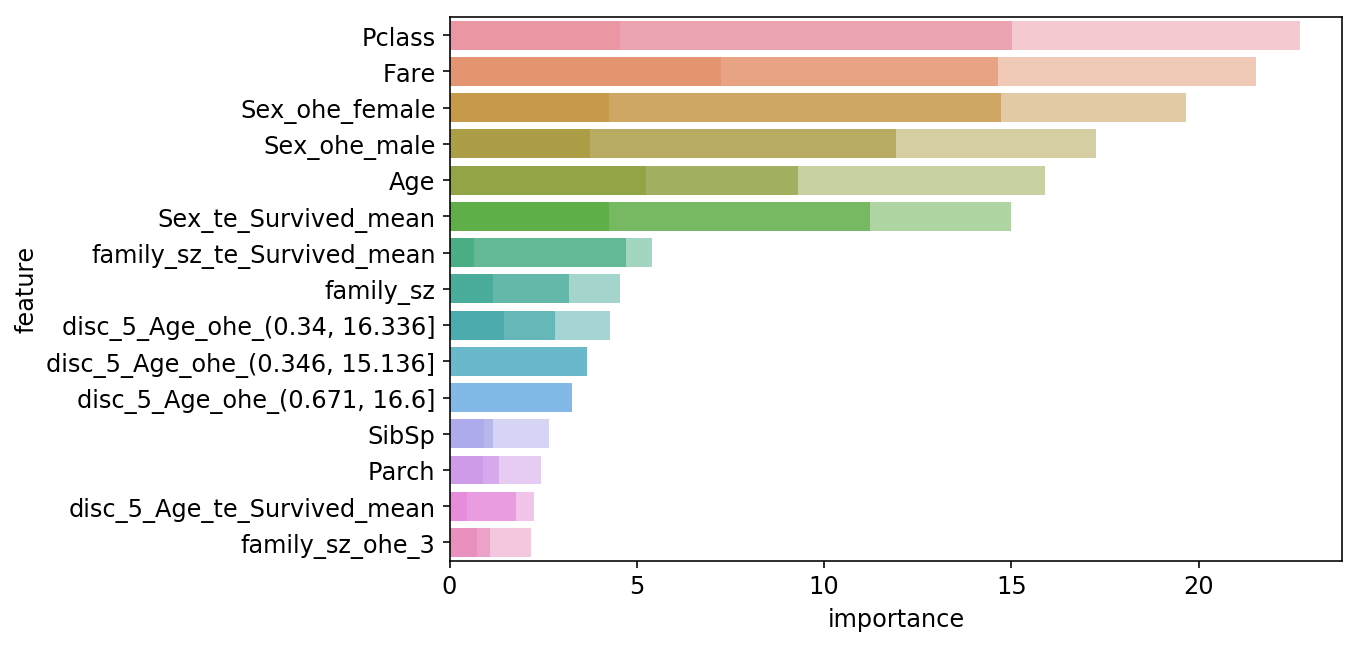

In [26]:
lb['6F5CC3'].feature_importances(plot=1)

Now we can select 20 best features from `fs_4` according to feature importances of experiment `6F5CC3`, which used `fs_4`:

In [21]:
fs_5 = fs_4.select(n_best=20, experiment=lb['6F5CC3'])

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [22]:
cb = zoo.bc.CatBoostClassifier()
val.score(cb, fs_5, description='same catboost, (numeric + family_sz + age + sex + f_sz encoded) select 20 best', verbose=500)

Learning rate set to 0.075294
0:	learn: 0.6494992	test: 0.6574022	best: 0.6574022 (0)	total: 23.6ms	remaining: 23.6s
500:	learn: 0.2669350	test: 0.4256309	best: 0.4196163 (330)	total: 4.36s	remaining: 4.35s
999:	learn: 0.2273449	test: 0.4450072	best: 0.4196163 (330)	total: 8.14s	remaining: 0us

bestTest = 0.4196163277
bestIteration = 330

Shrink model to first 331 iterations.
Learning rate set to 0.075294
0:	learn: 0.6470075	test: 0.6481424	best: 0.6481424 (0)	total: 20.3ms	remaining: 20.2s
500:	learn: 0.2241055	test: 0.5535879	best: 0.4533870 (19)	total: 4.91s	remaining: 4.89s
999:	learn: 0.1847317	test: 0.5937704	best: 0.4533870 (19)	total: 13.9s	remaining: 0us

bestTest = 0.4533870024
bestIteration = 19

Shrink model to first 20 iterations.
Learning rate set to 0.075305
0:	learn: 0.6588206	test: 0.6595439	best: 0.6595439 (0)	total: 16.3ms	remaining: 16.2s
500:	learn: 0.2503886	test: 0.3770480	best: 0.3747818 (303)	total: 7.64s	remaining: 7.61s
999:	learn: 0.2035214	test: 0.3829269	b

0.8747571576768648

Became worse, but my goal was to show the syntax. Feature selection becomes more efficient as you produce more features.

We have already conducted several experiments and are ready to proceed to `Stacking.ipynb`.